<a href="https://colab.research.google.com/github/mharisirfan/PROJ_ASD_ML/blob/main/Transfer_Learning_Unified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASD Detection: Unified Transfer Learning Pipeline

A streamlined pipeline for ASD detection from facial images using:
- **EfficientNetB0** and **ResNet50V2** backbones
- **Two-stage training** (frozen → fine-tuned)
- **Weighted loss** to minimize false negatives
- **Threshold optimization** for high recall
- **Grad-CAM interpretability**

## 1. Setup & Configuration

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from pathlib import Path
from dataclasses import dataclass
from typing import Callable, Tuple, Dict, Optional
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.regularizers import l2

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [32]:
@dataclass
class Config:
    """Centralized configuration for the pipeline."""
    # Data
    train_dir: str = '/content/drive/MyDrive/MTAT.03.227/AutismData/train'
    test_dir: str = '/content/drive/MyDrive/MTAT.03.227/AutismData/test'
    img_size: int = 224
    val_split: float = 0.2

    # Training
    batch_size_stage1: int = 32
    batch_size_stage2: int = 16
    lr_stage1: float = 1e-3
    lr_stage2: float = 1e-5
    epochs_stage1: int = 20
    epochs_stage2: int = 50
    fn_weight: float = 2.5  # False negative penalty
    target_recall: float = 0.95

    # Early stopping
    patience_stage1: int = 10
    patience_stage2: int = 15

    random_seed: int = 42

    inception_model_path: str = '/content/drive/MyDrive/MTAT.03.227/inceptionV3.h5'

cfg = Config()

## 2. Data Loading

In [4]:
def load_dataset(data_dir: str, img_size: int = 224) -> Tuple[np.ndarray, np.ndarray]:
    """Load and preprocess images from directory structure."""
    images, labels = [], []
    data_path = Path(data_dir)

    class_map = {'Autistic': 1, 'Non_Autistic': 0}
    valid_ext = {'.jpg', '.jpeg', '.png', '.bmp'}

    for class_name, label in class_map.items():
        class_dir = data_path / class_name
        if not class_dir.exists():
            print(f"Warning: {class_dir} not found")
            continue

        for img_path in class_dir.glob('*'):
            if img_path.suffix.lower() not in valid_ext:
                continue
            try:
                img = cv2.imread(str(img_path))
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(label)
            except Exception:
                continue

    X, y = np.array(images), np.array(labels)
    print(f"Loaded {len(y)} images | Autistic: {y.sum()} | Non-Autistic: {len(y) - y.sum()}")
    return X, y


def create_tf_dataset(X: np.ndarray, y: np.ndarray, preprocess_fn: Callable,
                      batch_size: int, shuffle: bool = True) -> tf.data.Dataset:
    """Create a tf.data pipeline with preprocessing."""
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=cfg.random_seed)
    ds = ds.batch(batch_size)
    ds = ds.map(
        lambda x, y: (preprocess_fn(tf.cast(x, tf.float32)), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return ds.prefetch(tf.data.AUTOTUNE)

In [5]:
# Load data
X_train_full, y_train_full = load_dataset(cfg.train_dir, cfg.img_size)
X_test, y_test = load_dataset(cfg.test_dir, cfg.img_size)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=cfg.val_split,
    stratify=y_train_full,
    random_state=cfg.random_seed
)

print(f"\nSplits → Train: {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}")
print(f"Positive rate → Train: {y_train.mean():.1%} | Val: {y_val.mean():.1%} | Test: {y_test.mean():.1%}")

Loaded 2317 images | Autistic: 1153 | Non-Autistic: 1164
Loaded 580 images | Autistic: 289 | Non-Autistic: 291

Splits → Train: 1853 | Val: 464 | Test: 580
Positive rate → Train: 49.8% | Val: 49.8% | Test: 49.8%


## 3. Model Factory

In [48]:
@dataclass
class ModelBundle:
    """Container for model, preprocessing, and metadata."""
    model: Model
    preprocess_fn: Callable
    base_model: Model
    name: str
    last_conv_layer: str
    unfreeze_layers: int


def build_model(architecture: str = 'efficientnet') -> ModelBundle:
    """
    Build ASD detection model with specified backbone.

    Args:
        architecture: 'efficientnet' or 'resnet'
    """
    input_shape = (cfg.img_size, cfg.img_size, 3)

    if architecture == 'efficientnet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess_fn = tf.keras.applications.efficientnet.preprocess_input
        name = 'EfficientNet-B0'
        last_conv_layer = 'top_conv'
        unfreeze_layers = 20
        dense_units = 128
    elif architecture == 'resnet':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocess_fn = tf.keras.applications.resnet_v2.preprocess_input
        name = 'ResNet50V2'
        last_conv_layer = 'conv5_block3_out'
        unfreeze_layers = 30
        dense_units = 256
    elif architecture == 'inception':
        base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
        preprocess_fn = tf.keras.applications.inception_v3.preprocess_input
        name = 'Inception-v3'
        last_conv_layer = 'mixed10'  # Inception's final conv block
        unfreeze_layers = 30
        dense_units = 256
    else:
        raise ValueError(f"Unknown architecture: {architecture}")

    # Freeze backbone
    base_model.trainable = False

    # Classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    if architecture == 'resnet':
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    return ModelBundle(model, preprocess_fn, base_model, name, last_conv_layer, unfreeze_layers)


def unfreeze_top_layers(bundle: ModelBundle) -> None:
    """Unfreeze top layers for fine-tuning (Stage 2)."""
    bundle.base_model.trainable = True
    for layer in bundle.base_model.layers[:-bundle.unfreeze_layers]:
        layer.trainable = False

    trainable_params = sum(tf.keras.backend.count_params(w) for w in bundle.model.trainable_weights)
    print(f"Unfroze last {bundle.unfreeze_layers} layers | Trainable params: {trainable_params:,}")


def load_pretrained_model(model_path: str, architecture: str = 'inception',
                          preprocess_mode: str = 'inception',
                          invert_output: bool = False) -> ModelBundle:
    """Load pre-trained model with optional output inversion."""
    base_model = tf.keras.models.load_model(model_path, compile=False)

    if preprocess_mode == 'inception':
        preprocess_fn = tf.keras.applications.inception_v3.preprocess_input
    elif preprocess_mode == 'normalize':
        preprocess_fn = lambda x: x / 255.0
    else:
        preprocess_fn = lambda x: x

    # Wrap model to invert output if needed
    if invert_output:
        inputs = base_model.input
        outputs = 1 - base_model.output
        model = Model(inputs=inputs, outputs=outputs)
    else:
        model = base_model

    return ModelBundle(
        model=model,
        preprocess_fn=preprocess_fn,
        base_model=None,
        name='Inception-V3',
        last_conv_layer='mixed10',
        unfreeze_layers=0
    )

## 4. Loss & Metrics

In [7]:
def weighted_bce(fn_weight: float = 2.5):
    """
    Weighted binary cross-entropy that penalizes false negatives.
    For ASD screening, missing a case is worse than a false alarm.
    """
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        weight = y_true * fn_weight + (1 - y_true)
        return tf.reduce_mean(weight * bce)
    return loss


def get_metrics():
    """Standard metrics for binary classification."""
    return ['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]

## 5. Training Pipeline

In [8]:
def train_model(bundle: ModelBundle, X_train: np.ndarray, y_train: np.ndarray,
                X_val: np.ndarray, y_val: np.ndarray) -> Dict:
    """
    Two-stage training: frozen backbone → fine-tuning.
    Returns training histories for both stages.
    """
    histories = {}

    # ─────────────────────────────────────────────────────────────────────────
    # Stage 1: Train classification head only
    # ─────────────────────────────────────────────────────────────────────────
    print(f"\n{'='*60}")
    print(f"{bundle.name} - Stage 1: Training classification head")
    print(f"{'='*60}")

    train_ds = create_tf_dataset(X_train, y_train, bundle.preprocess_fn, cfg.batch_size_stage1)
    val_ds = create_tf_dataset(X_val, y_val, bundle.preprocess_fn, cfg.batch_size_stage1, shuffle=False)

    bundle.model.compile(
        optimizer=Adam(learning_rate=cfg.lr_stage1),
        loss=weighted_bce(cfg.fn_weight),
        metrics=get_metrics()
    )

    trainable = sum(tf.keras.backend.count_params(w) for w in bundle.model.trainable_weights)
    print(f"Trainable params: {trainable:,}")

    callbacks_s1 = [
        EarlyStopping(monitor='val_recall', patience=cfg.patience_stage1, mode='max', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    ]

    histories['stage1'] = bundle.model.fit(
        train_ds, validation_data=val_ds,
        epochs=cfg.epochs_stage1, callbacks=callbacks_s1
    )

    # ─────────────────────────────────────────────────────────────────────────
    # Stage 2: Fine-tune top layers
    # ─────────────────────────────────────────────────────────────────────────
    print(f"\n{'='*60}")
    print(f"{bundle.name} - Stage 2: Fine-tuning top layers")
    print(f"{'='*60}")

    unfreeze_top_layers(bundle)

    # Smaller batch size and lower LR for fine-tuning
    train_ds_ft = create_tf_dataset(X_train, y_train, bundle.preprocess_fn, cfg.batch_size_stage2)
    val_ds_ft = create_tf_dataset(X_val, y_val, bundle.preprocess_fn, cfg.batch_size_stage2, shuffle=False)

    bundle.model.compile(
        optimizer=Adam(learning_rate=cfg.lr_stage2),
        loss=weighted_bce(cfg.fn_weight),
        metrics=get_metrics()
    )

    model_path = f'best_{bundle.name.lower().replace("-", "_")}_asd.keras'
    callbacks_s2 = [
        EarlyStopping(monitor='val_recall', patience=cfg.patience_stage2, mode='max', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
        ModelCheckpoint(model_path, monitor='val_recall', mode='max', save_best_only=True)
    ]

    histories['stage2'] = bundle.model.fit(
        train_ds_ft, validation_data=val_ds_ft,
        epochs=cfg.epochs_stage2, callbacks=callbacks_s2
    )

    print(f"\n✓ Model saved: {model_path}")
    return histories

## 6. Evaluation & Threshold Optimization

In [63]:
def find_optimal_threshold(y_true: np.ndarray, y_proba: np.ndarray,
                           target_recall: float = 0.95) -> float:
    """Find threshold achieving target recall with maximum precision."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba.flatten())

    valid_idx = recalls[:-1] >= target_recall
    if not valid_idx.any():
        # Fallback to Youden's J if target recall unachievable
        best_idx = np.argmax(recalls[:-1] + precisions[:-1] - 1)
        print(f"Warning: Cannot achieve {target_recall:.0%} recall. Using Youden's J.")
    else:
        best_idx = np.where(valid_idx)[0][np.argmax(precisions[:-1][valid_idx])]

    threshold = thresholds[best_idx]
    print(f"Optimal threshold: {threshold:.3f} → Recall: {recalls[best_idx]:.3f}, Precision: {precisions[best_idx]:.3f}")
    return threshold


def evaluate_model(bundle: ModelBundle, X: np.ndarray, y: np.ndarray,
                   threshold: float = 0.5) -> Dict:
    """Comprehensive model evaluation with custom threshold."""
    y_proba = bundle.model.predict(bundle.preprocess_fn(X.astype('float32')), verbose=0).flatten()
    y_pred = (y_proba >= threshold).astype(int)

    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()

    metrics = {
        'accuracy': (tp + tn) / len(y),
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'fnr': fn / (fn + tp) if (fn + tp) > 0 else 0,
        'false_negatives': fn,
        'threshold': threshold
    }

    print(f"\n{bundle.name} Evaluation (threshold={threshold:.3f})")
    print("-" * 50)
    print(classification_report(y, y_pred, target_names=['Non_Autistic', 'Autistic']))
    print(f"Confusion Matrix:")
    print(f"              Pred ASD  Pred Non")
    print(f"  Actual ASD    {tp:4d}      {fn:4d}")
    print(f"  Actual Non    {fp:4d}      {tn:4d}")
    print(f"\nScreening: Sensitivity={metrics['recall']:.3f}, Specificity={metrics['specificity']:.3f}, FNR={metrics['fnr']:.3f}")

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap='Blues')

    # Labels and ticks
    labels = ['Non_Autistic', 'Autistic']
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'{bundle.name}\nAccuracy: {metrics["accuracy"]:.1%} | Threshold: {threshold:.3f}', fontsize=12)

    # Annotate cells with counts and percentages
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            pct = count / len(y) * 100
            color = 'white' if count > cm.max() / 2 else 'black'
            ax.text(j, i, f'{count}\n({pct:.1f}%)', ha='center', va='center',
                    color=color, fontsize=14, fontweight='bold')

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    return {'proba': y_proba, 'pred': y_pred, 'metrics': metrics}

## 7. Grad-CAM Interpretability

In [10]:
def compute_gradcam(img_array: np.ndarray, model: Model, last_conv_layer: str) -> np.ndarray:
    """Generate Grad-CAM heatmap for model interpretability."""
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        loss = preds[:, 0]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = conv_out[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


def overlay_heatmap(image: np.ndarray, heatmap: np.ndarray, alpha: float = 0.4) -> np.ndarray:
    """Overlay Grad-CAM heatmap on original image."""
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    return cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)


def explain_prediction(bundle: ModelBundle, image: np.ndarray,
                       true_label: Optional[int] = None) -> Tuple[float, np.ndarray]:
    """Visualize Grad-CAM explanation for a single prediction."""
    img_array = bundle.preprocess_fn(np.expand_dims(image.astype('float32'), axis=0))
    pred = bundle.model.predict(img_array, verbose=0)[0, 0]
    heatmap = compute_gradcam(img_array, bundle.model, bundle.last_conv_layer)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Original
    axes[0].imshow(image)
    title = 'Original'
    if true_label is not None:
        title += f"\nTrue: {'Autistic' if true_label == 1 else 'Non-Autistic'}"
    axes[0].set_title(title)
    axes[0].axis('off')

    # Heatmap
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Attention Heatmap')
    axes[1].axis('off')

    # Overlay
    overlay = overlay_heatmap(image, heatmap)
    axes[2].imshow(overlay)
    pred_label = 'Autistic' if pred >= 0.5 else 'Non-Autistic'

    if true_label is not None:
        correct = (pred >= 0.5) == (true_label == 1)
        status = '✓' if correct else '✗'
        color = 'green' if correct else 'red'
        axes[2].set_title(f'Pred: {pred_label} ({pred:.2f}) {status}', color=color)
    else:
        axes[2].set_title(f'Pred: {pred_label} ({pred:.2f})')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return pred, heatmap

## 8. Model Comparison

In [62]:
def compare_models(bundles: Dict[str, Tuple[ModelBundle, float]],
                   X_test: np.ndarray, y_test: np.ndarray) -> pd.DataFrame:
    """
    Compare multiple models on the same test set.

    Args:
        bundles: Dict of {'name': (ModelBundle, threshold)}
    """
    results = []

    for name, (bundle, threshold) in bundles.items():
        y_proba = bundle.model.predict(bundle.preprocess_fn(X_test.astype('float32')), verbose=0).flatten()
        y_pred = (y_proba >= threshold).astype(int)

        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        results.append({
            'Model': name,
            'Accuracy': (tp + tn) / len(y_test),
            'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'False Negatives': fn,
            'Threshold': threshold
        })

    df = pd.DataFrame(results)
    print("\n" + "=" * 70)
    print("MODEL COMPARISON - ASD Detection Performance")
    print("=" * 70)
    print(df.to_string(index=False))
    print("\nNote: For screening, prioritize Recall (minimize False Negatives)")

    return df


def plot_training_comparison(histories: Dict[str, Dict], metric: str = 'auc') -> None:
    """Plot training curves for multiple models on the same scale."""
    n_models = len(histories)
    fig, axes = plt.subplots(1, n_models, figsize=(7 * n_models, 5))
    if n_models == 1:
        axes = [axes]

    # Compute shared y-limits
    all_values = []
    for h in histories.values():
        hist = h['stage2'].history
        all_values.extend(hist[metric] + hist[f'val_{metric}'])
    y_min, y_max = min(all_values) - 0.02, max(all_values) + 0.02

    for ax, (name, h) in zip(axes, histories.items()):
        hist = h['stage2'].history
        ax.plot(hist[metric], label=f'Train {metric}')
        ax.plot(hist[f'val_{metric}'], label=f'Val {metric}')
        ax.set_title(name)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.upper())
        ax.set_ylim(y_min, y_max)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

---
## 9. Run Pipeline

Execute the full training and evaluation pipeline for both models.

In [12]:
# ═══════════════════════════════════════════════════════════════════════════════
# Train EfficientNet
# ═══════════════════════════════════════════════════════════════════════════════
eff_bundle = build_model('efficientnet')
eff_bundle.model.summary()

eff_histories = train_model(eff_bundle, X_train, y_train, X_val, y_val)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,180 (16.08 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 4,049,827 (15.45 MB)


EfficientNet-B0 - Stage 1: Training classification head
Trainable params: 164,353
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 685ms/step - accuracy: 0.6548 - auc: 0.7114 - loss: 3.4663 - precision: 0.6511 - recall: 0.6707 - val_accuracy: 0.7155 - val_auc: 0.8571 - val_loss: 2.7544 - val_precision: 0.8667 - val_recall: 0.5065 - learning_rate: 0.0010
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7551 - auc: 0.8203 - loss: 2.6395 - precision: 0.7450 - recall: 0.7601 - val_accuracy: 0.7629 - val_auc: 0.8651 - val_loss: 2.2789 - val_precision: 0.7763 - val_recall: 0.7359 - learning_rate: 0.0010
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7569 - auc: 0.8388 - loss: 2.2279 - precision: 0.7433 - recall: 0.7779 - val_accuracy: 0.7672 - val_auc: 0.8737 - val_loss: 1.9830 - val_precision: 0.8254 - val_recall: 0.6753 - learning_rate: 0.0010
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7859 - auc: 0.8651 - loss: 1.9378 - precision: 0.7899 -

Optimal threshold: 0.078 → Recall: 0.957, Precision: 0.650

EfficientNet-B0 Evaluation (threshold=0.078)
--------------------------------------------------
              precision    recall  f1-score   support

Non_Autistic       0.88      0.43      0.58       291
    Autistic       0.62      0.94      0.75       289

    accuracy                           0.69       580
   macro avg       0.75      0.69      0.66       580
weighted avg       0.75      0.69      0.66       580

Confusion Matrix:
              Pred ASD  Pred Non
  Actual ASD     272        17
  Actual Non     165       126

Screening: Sensitivity=0.941, Specificity=0.433, FNR=0.059


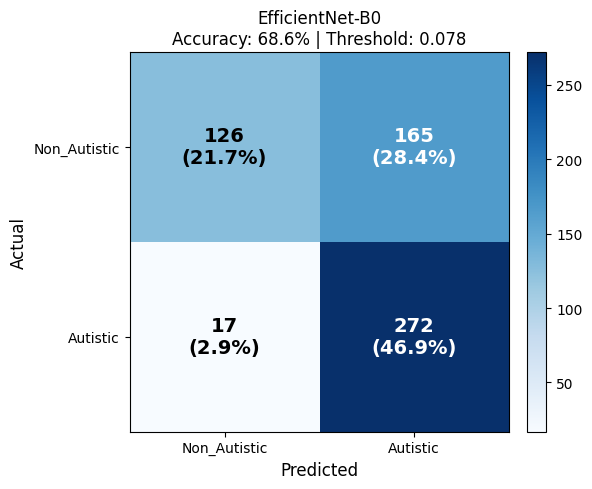

In [64]:
# Find optimal threshold & evaluate EfficientNet
y_val_proba_eff = eff_bundle.model.predict(eff_bundle.preprocess_fn(X_val.astype('float32')), verbose=0)
threshold_eff = find_optimal_threshold(y_val, y_val_proba_eff, cfg.target_recall)

eff_results = evaluate_model(eff_bundle, X_test, y_test, threshold_eff)

In [14]:
# ═══════════════════════════════════════════════════════════════════════════════
# Train ResNet
# ═══════════════════════════════════════════════════════════════════════════════
res_bundle = build_model('resnet')
res_bundle.model.summary()

res_histories = train_model(res_bundle, X_train, y_train, X_val, y_val)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,106,881 (91.96 MB)

 Trainable params: 541,569 (2.07 MB)

 Non-trainable params: 23,565,312 (89.89 MB)


ResNet50V2 - Stage 1: Training classification head
Trainable params: 541,569
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 420ms/step - accuracy: 0.6081 - auc: 0.6442 - loss: 5.0815 - precision: 0.6102 - recall: 0.6060 - val_accuracy: 0.7155 - val_auc: 0.8393 - val_loss: 3.3067 - val_precision: 0.6486 - val_recall: 0.9351 - learning_rate: 0.0010
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.7336 - auc: 0.8003 - loss: 3.1102 - precision: 0.7348 - recall: 0.7141 - val_accuracy: 0.7716 - val_auc: 0.8530 - val_loss: 2.5846 - val_precision: 0.7240 - val_recall: 0.8745 - learning_rate: 0.0010
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.7335 - auc: 0.8077 - loss: 2.5473 - precision: 0.7353 - recall: 0.7198 - val_accuracy: 0.7565 - val_auc: 0.8411 - val_loss: 2.2014 - val_precision: 0.7731 - val_recall: 0.7229 - learning_rate: 0.0010
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.7514 - auc: 0.8398 - loss: 2.1292 - precision: 0.7528 - rec

Optimal threshold: 0.199 → Recall: 0.952, Precision: 0.625

ResNet50V2 Evaluation (threshold=0.199)
--------------------------------------------------
              precision    recall  f1-score   support

Non_Autistic       0.88      0.38      0.53       291
    Autistic       0.60      0.94      0.74       289

    accuracy                           0.66       580
   macro avg       0.74      0.66      0.64       580
weighted avg       0.74      0.66      0.64       580

Confusion Matrix:
              Pred ASD  Pred Non
  Actual ASD     273        16
  Actual Non     179       112

Screening: Sensitivity=0.945, Specificity=0.385, FNR=0.055


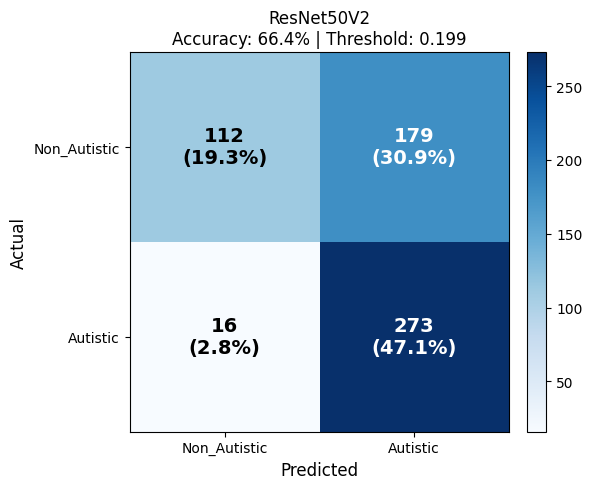

In [66]:
# Find optimal threshold & evaluate ResNet
y_val_proba_res = res_bundle.model.predict(res_bundle.preprocess_fn(X_val.astype('float32')), verbose=0)
threshold_res = find_optimal_threshold(y_val, y_val_proba_res, cfg.target_recall)

res_results = evaluate_model(res_bundle, X_test, y_test, threshold_res)

Inception-v3

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,852,385 (87.17 MB)

 Trainable params: 20,249,473 (77.25 MB)

 Non-trainable params: 2,602,912 (9.93 MB)

Loaded 2317 images | Autistic: 1153 | Non-Autistic: 1164
Loaded 580 images | Autistic: 289 | Non-Autistic: 291
Optimal threshold: 0.192 → Recall: 0.957, Precision: 0.749

Inception-V3 Evaluation (threshold=0.192)
--------------------------------------------------
              precision    recall  f1-score   support

Non_Autistic       0.89      0.57      0.70       291
    Autistic       0.68      0.93      0.79       289

    accuracy                           0.75       580
   macro avg       0.79      0.75      0.74       580
weighted avg       0.79      0.75      0.74       580

Confusion Matrix:
              Pred ASD  Pred Non
  Actual ASD     269        20
  Actual Non     125       166

Screening: Sensitivity=0.931, Specificity=0.570, FNR=0.069


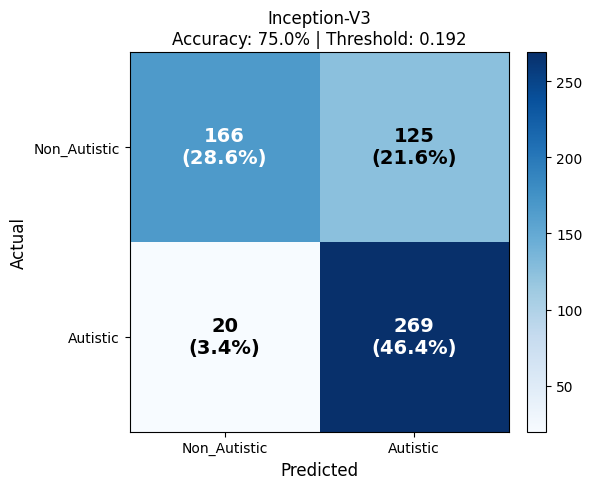

In [67]:
# Load Inception with inverted output
inc_bundle = load_pretrained_model(
    cfg.inception_model_path,
    architecture='inception',
    preprocess_mode='inception',
    invert_output=True
)

inc_bundle.model.summary()

# Load data at 299×299 for Inception
X_train_full_299, _ = load_dataset(cfg.train_dir, img_size=299)
X_test_299, _ = load_dataset(cfg.test_dir, img_size=299)

# Split to get validation set (same indices as original split)
X_train_299, X_val_299, _, _ = train_test_split(
    X_train_full_299, y_train_full,
    test_size=cfg.val_split,
    stratify=y_train_full,
    random_state=cfg.random_seed  # Same seed = same split
)

# Find optimal threshold & evaluate
y_val_proba_inc = inc_bundle.model.predict(inc_bundle.preprocess_fn(X_val_299.astype('float32')), verbose=0)
threshold_inc = find_optimal_threshold(y_val, y_val_proba_inc, target_recall=0.95)

inc_results = evaluate_model(inc_bundle, X_test_299, y_test, threshold_inc)

# 10. Model comparisons


MODEL COMPARISON - ASD Detection Performance
          Model  Accuracy   Recall  Precision  Specificity  False Negatives  Threshold
EfficientNet-B0  0.686207 0.941176   0.622426     0.432990               17   0.077745
   Inception-V3  0.789655 0.861592   0.752266     0.718213               40   0.192239

Note: For screening, prioritize Recall (minimize False Negatives)


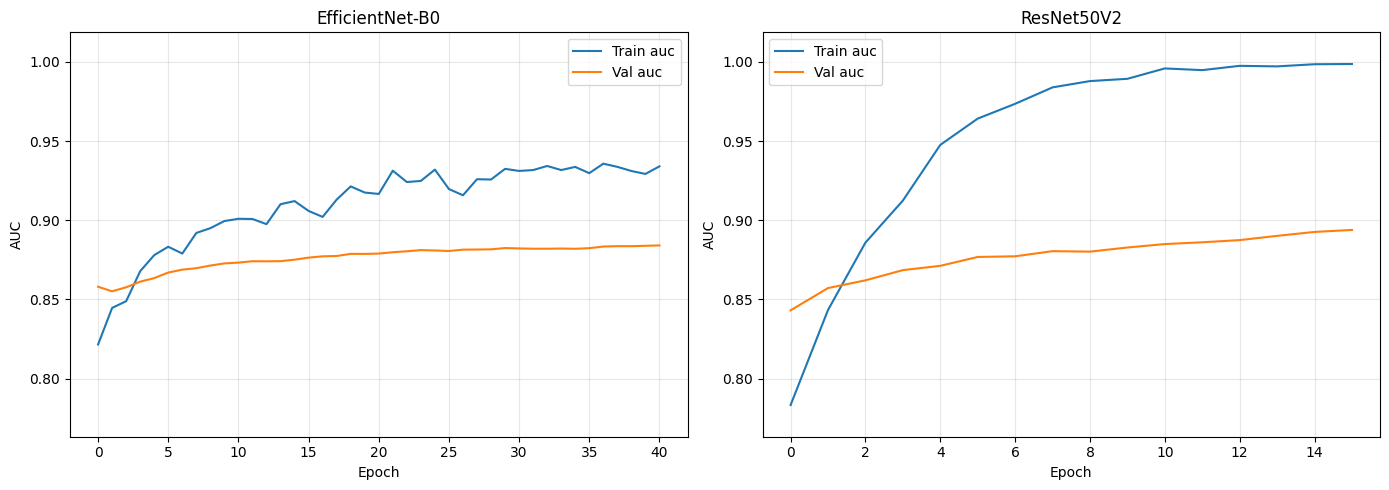

In [68]:
# ═══════════════════════════════════════════════════════════════════════════════
# Compare Models
# ═══════════════════════════════════════════════════════════════════════════════
comparison_df = compare_models(
    {
        'EfficientNet-B0': (eff_bundle, threshold_eff),
        # 'ResNet50V2': (res_bundle, threshold_res),
        'Inception-V3': (inc_bundle, threshold_inc)
    },
    X_test, y_test
)

plot_training_comparison(
    {'EfficientNet-B0': eff_histories, 'ResNet50V2': res_histories},
    metric='auc'
)  # Note: Inception has no training history to plot

## 11. Grad-CAM Visualizations

EfficientNet-B0 Grad-CAM Explanations
----------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


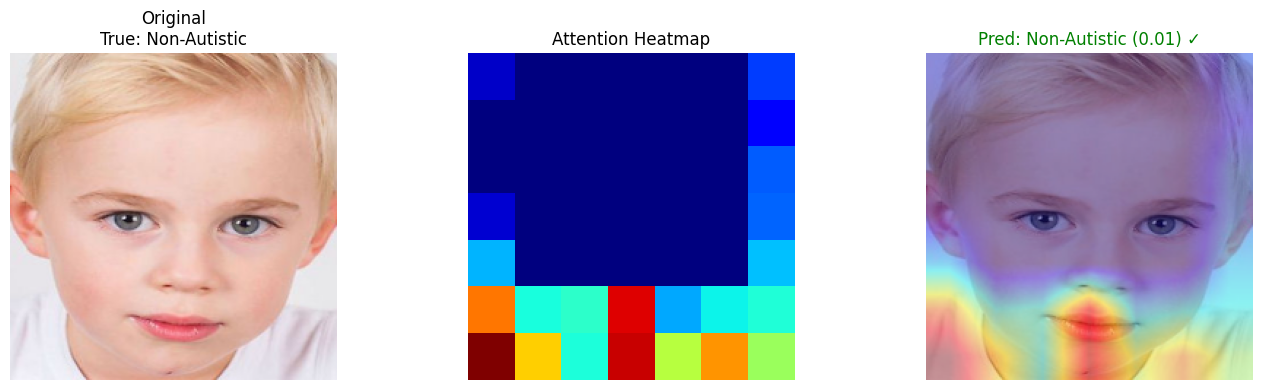

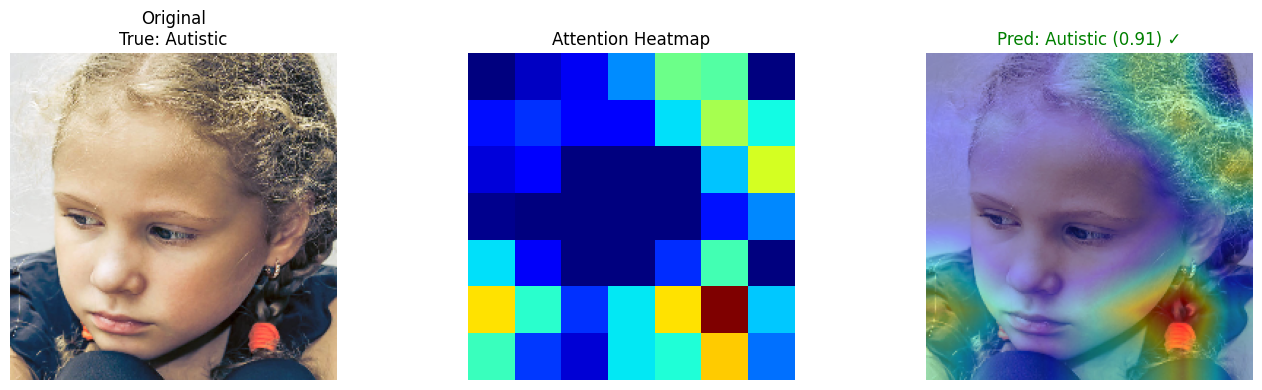

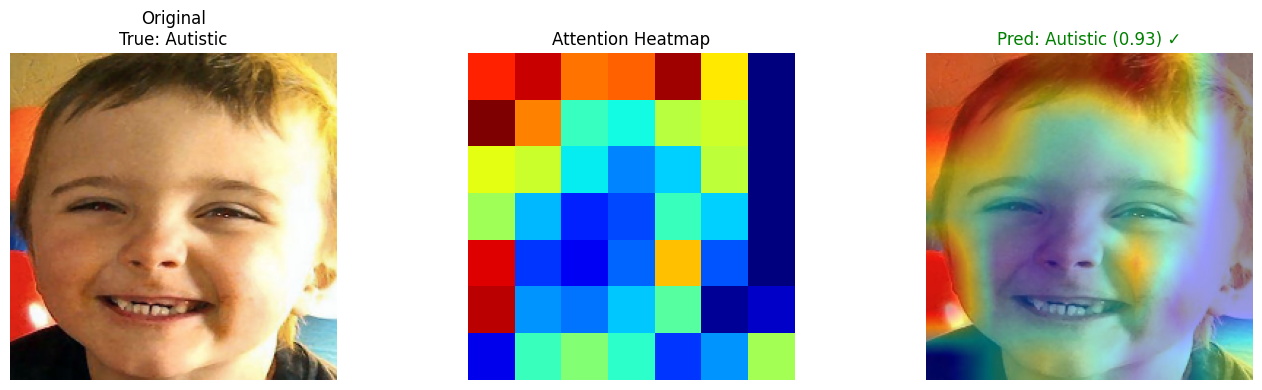

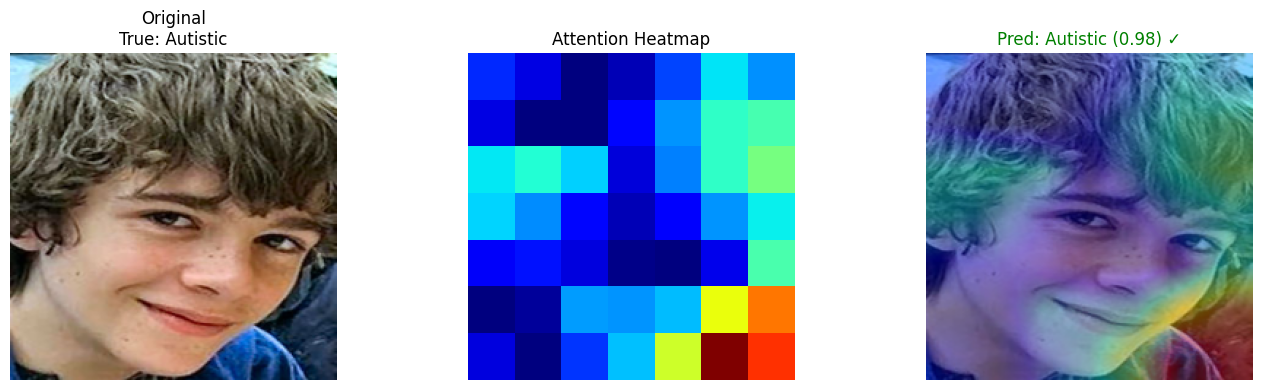

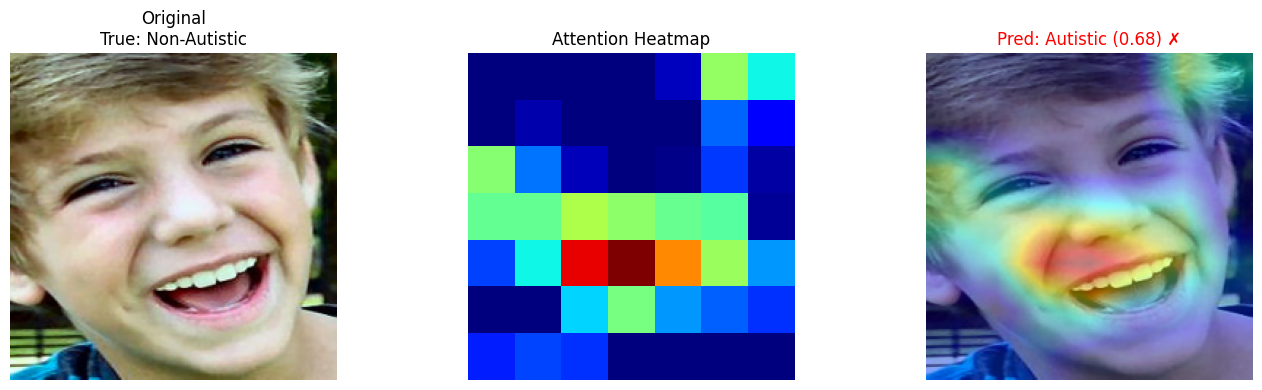

In [69]:
# Visualize predictions from both models
np.random.seed(cfg.random_seed)
sample_indices = np.random.choice(len(X_test), 5, replace=False)

print("EfficientNet-B0 Grad-CAM Explanations")
print("-" * 40)
for idx in sample_indices:
    explain_prediction(eff_bundle, X_test[idx], true_label=y_test[idx])

ResNet50V2 Grad-CAM Explanations
----------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_244']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


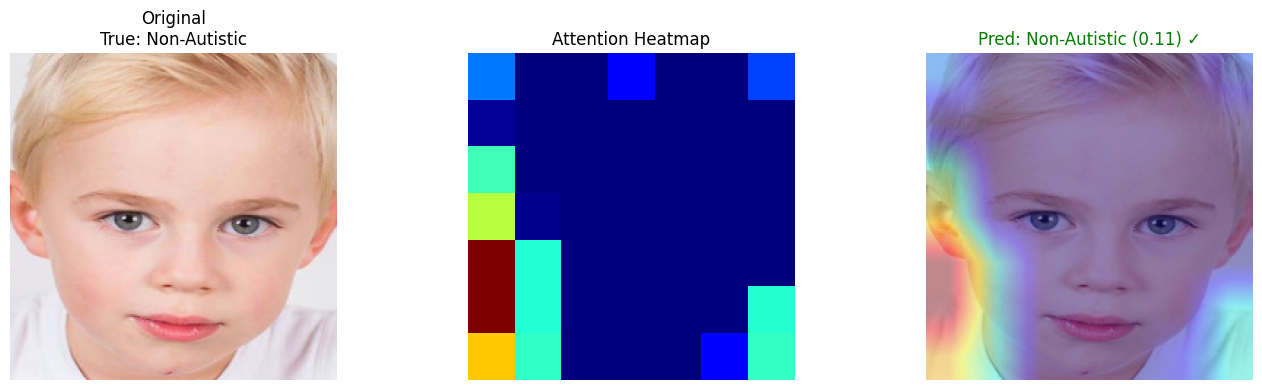

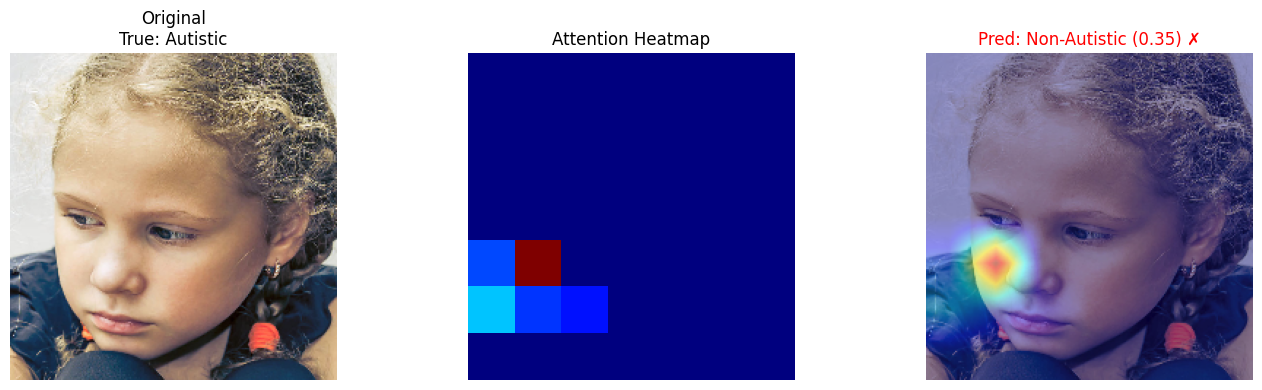

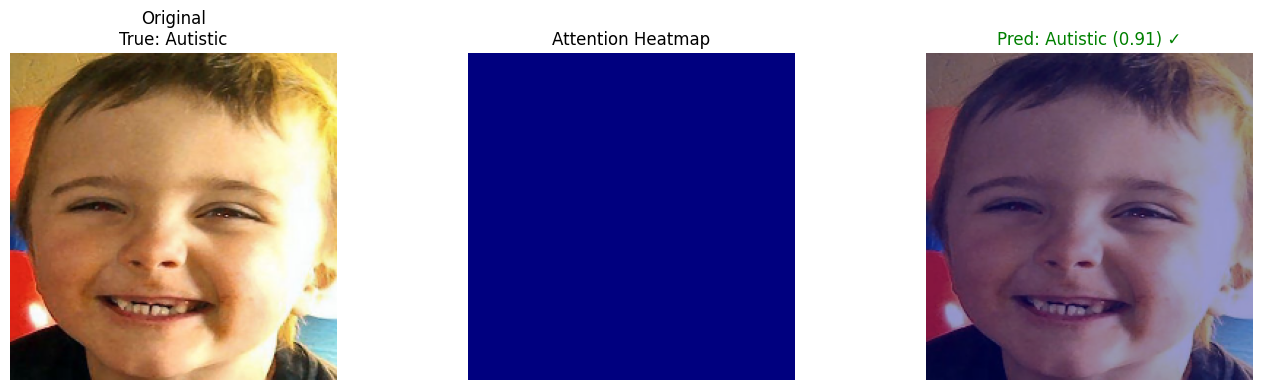

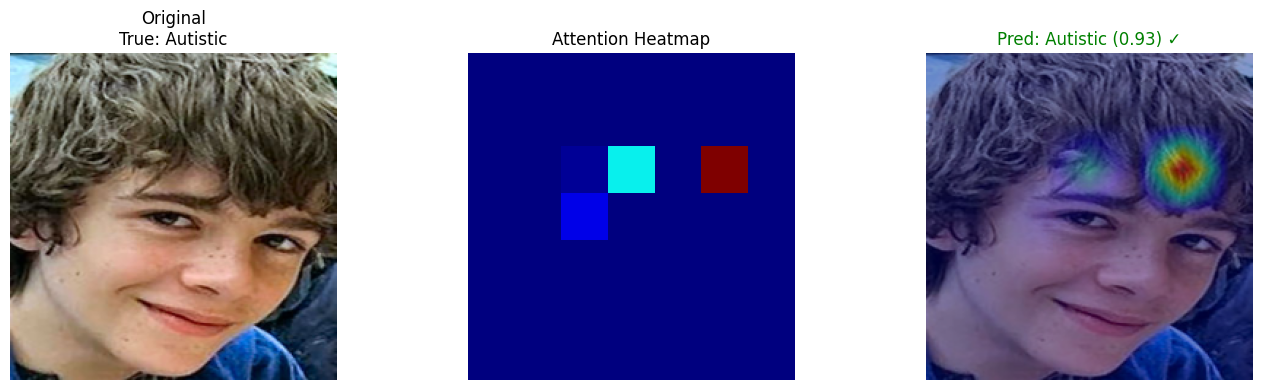

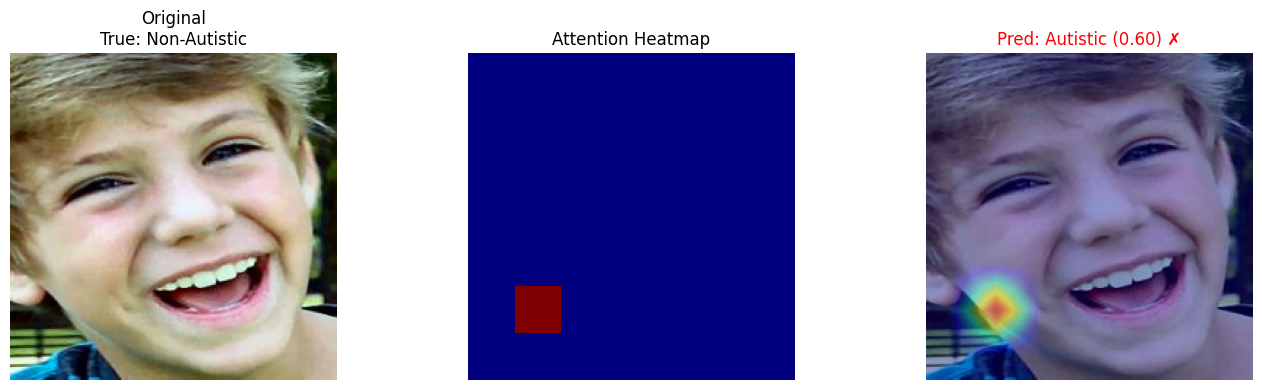

In [70]:
print("ResNet50V2 Grad-CAM Explanations")
print("-" * 40)
for idx in sample_indices:
    explain_prediction(res_bundle, X_test[idx], true_label=y_test[idx])

Inception-V3 Grad-CAM Explanations
----------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


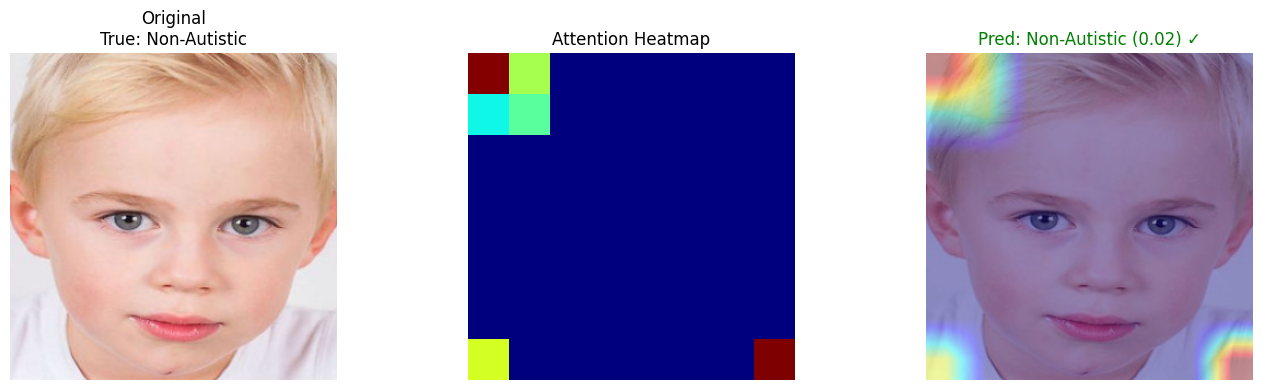

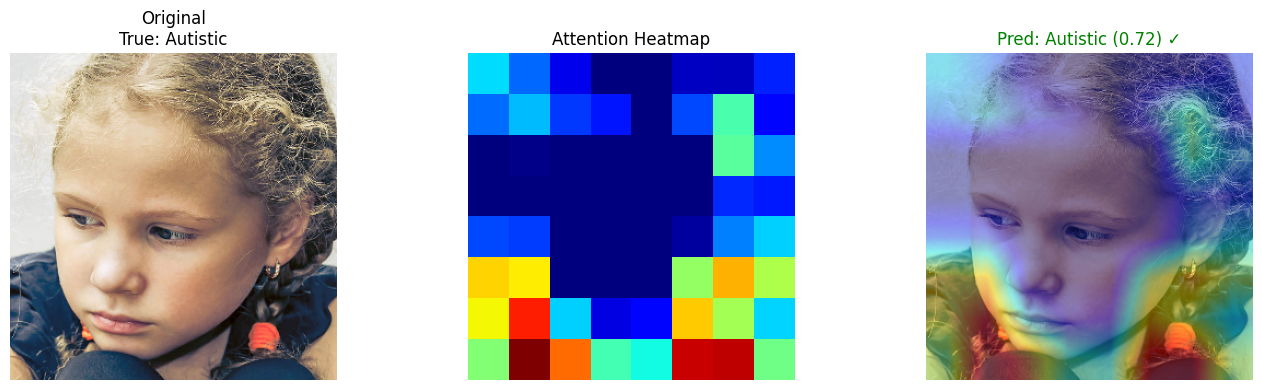

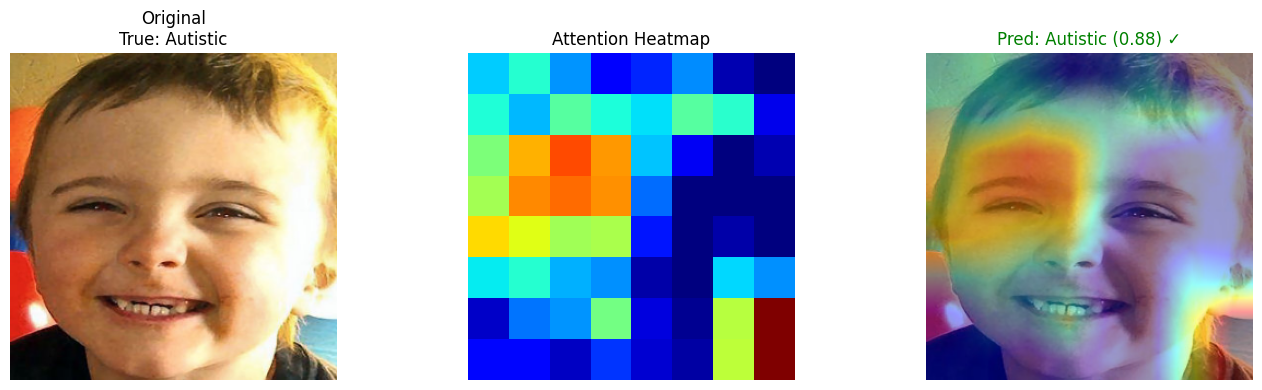

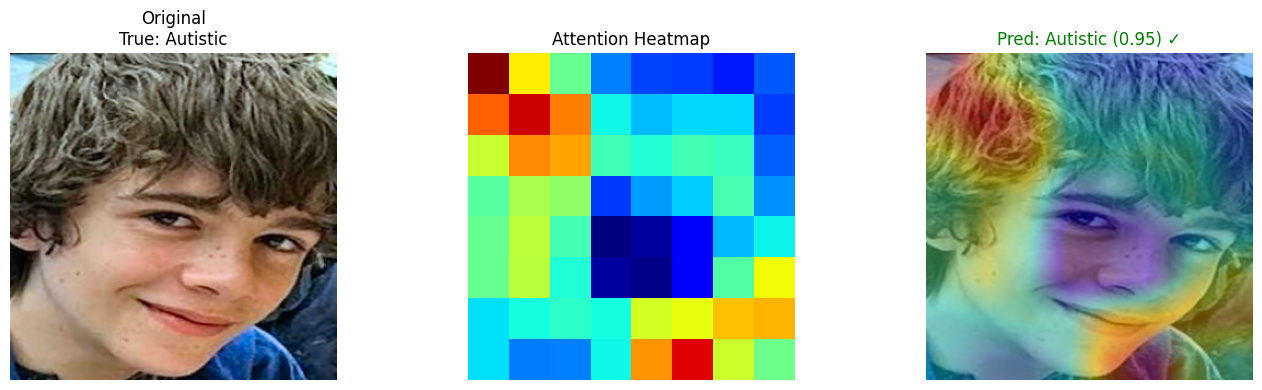

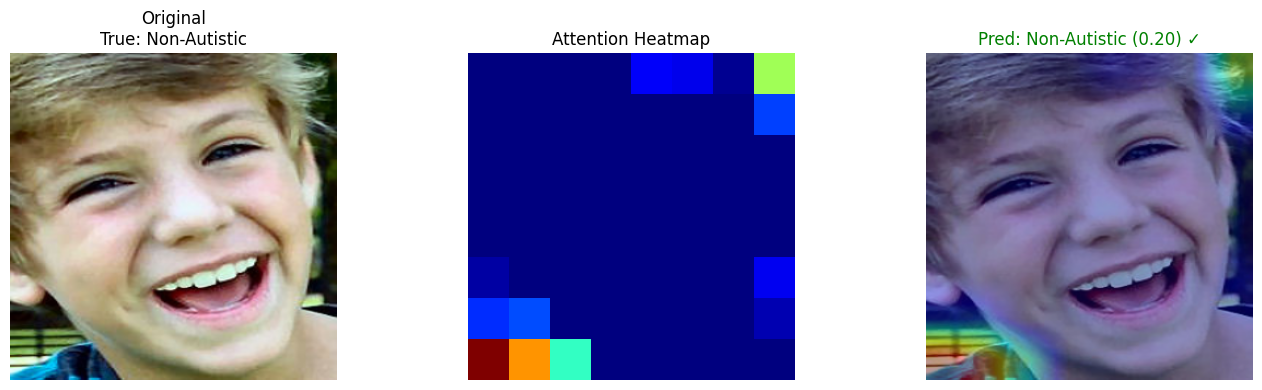

In [71]:
print("Inception-V3 Grad-CAM Explanations")
print("-" * 40)
for idx in sample_indices:
    explain_prediction(inc_bundle, X_test_299[idx], true_label=y_test[idx])